UNCOMMENT TO INSTALL EVERYTHING FIRST

In [120]:

# !pip install numpy
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install cv2
# !pip install glob2
# !pip install PIL
# !pip install IPython
# !pip install opencv-python

In [121]:
#Import Dependencies
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import cv2
from glob import glob

In [122]:
#contd
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model,load_img,img_to_array, array_to_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image

Avoid using if cuda is not installed

In [123]:
#Avoid OOM error
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [124]:
tf.config.list_physical_devices('GPU') #GPU is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [125]:
#LOAD DATA
DATA_DIR = r".\stanford-dataset"
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_id', 'image_path', 'label_colored_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['label_colored_path'] = metadata_df['label_colored_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(643, 72)

In [126]:
metadata_df

,image_id,image_path,label_colored_path
0,6000202,.\stanford-dataset\images/6000202.jpg,.\stanford-dataset\labels_colored/6000202.png
1,3178,.\stanford-dataset\images/0003178.jpg,.\stanford-dataset\labels_colored/0003178.png
2,6000163,.\stanford-dataset\images/6000163.jpg,.\stanford-dataset\labels_colored/6000163.png
3,6000159,.\stanford-dataset\images/6000159.jpg,.\stanford-dataset\labels_colored/6000159.png
4,2000037,.\stanford-dataset\images/2000037.jpg,.\stanford-dataset\labels_colored/2000037.png
...,...,...,...
710,5000173,.\stanford-dataset\images/5000173.jpg,.\stanford-dataset\labels_colored/5000173.png
711,6000158,.\stanford-dataset\images/6000158.jpg,.\stanford-dataset\labels_colored/6000158.png
712,9000029,.\stanford-dataset\images/9000029.jpg,.\stanford-dataset\labels_colored/9000029.png
713,6000229,.\stanford-dataset\images/6000229.jpg,.\stanford-dataset\labels_colored/6000229.png


In [127]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'labels_class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('class_names : ', class_names)
print('class_rgb_values : ', class_rgb_values)

class_names :  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
class_rgb_values :  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]


In [128]:
# Creation of the test_set and the valid_set as paths

train_images_paths = train_df['image_path'].tolist()
train_masks_paths = train_df['label_colored_path'].tolist()

valid_images_paths = valid_df['image_path'].tolist()
valid_masks_paths = valid_df['label_colored_path'].tolist()
valid_images_paths

['.\\stanford-dataset\\images/5000200.jpg',
 '.\\stanford-dataset\\images/6000218.jpg',
 '.\\stanford-dataset\\images/6000294.jpg',
 '.\\stanford-dataset\\images/5000124.jpg',
 '.\\stanford-dataset\\images/1000505.jpg',
 '.\\stanford-dataset\\images/0100579.jpg',
 '.\\stanford-dataset\\images/5000123.jpg',
 '.\\stanford-dataset\\images/1100009.jpg',
 '.\\stanford-dataset\\images/0011033.jpg',
 '.\\stanford-dataset\\images/6000019.jpg',
 '.\\stanford-dataset\\images/9004971.jpg',
 '.\\stanford-dataset\\images/6000056.jpg',
 '.\\stanford-dataset\\images/6000069.jpg',
 '.\\stanford-dataset\\images/6000242.jpg',
 '.\\stanford-dataset\\images/6000046.jpg',
 '.\\stanford-dataset\\images/1100011.jpg',
 '.\\stanford-dataset\\images/6000063.jpg',
 '.\\stanford-dataset\\images/2000030.jpg',
 '.\\stanford-dataset\\images/6000158.jpg',
 '.\\stanford-dataset\\images/6000070.jpg',
 '.\\stanford-dataset\\images/6000114.jpg',
 '.\\stanford-dataset\\images/1000288.jpg',
 '.\\stanford-dataset\\images/01

In [129]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

In [130]:
def DataGenerator(images_paths, masks_paths, batch_size=10):
    while True :
        for i in range(0, len(images_paths), batch_size):
            #batch_files = df_path[i : i+batch_size]
            imgs=[]
            masks=[]
            for j in range(i,i+batch_size):
            #for file in batch_files:
                #file = random.sample(files,1)[0]
                #image = cv2.cvtColor(cv2.resize(cv2.imread(images_paths[j]),(224,224)),cv2.COLOR_RGB2BGR)
                image = cv2.resize(cv2.imread(images_paths[j]),(224,224))  #incase of size change
                mask = cv2.cvtColor(cv2.resize(cv2.imread(masks_paths[j]),(224,224)),cv2.COLOR_RGB2BGR)
                mask = one_hot_encode(mask, class_rgb_values).astype('float')
                
                imgs.append(image)
                masks.append(mask)
                
            yield np.array(imgs), np.array(masks)    

In [131]:

# train_set generator and valid_set generaor
train_gen = DataGenerator(train_images_paths[:-3], train_masks_paths[:-3])
valid_gen = DataGenerator(valid_images_paths[:-2], valid_masks_paths[:-2])

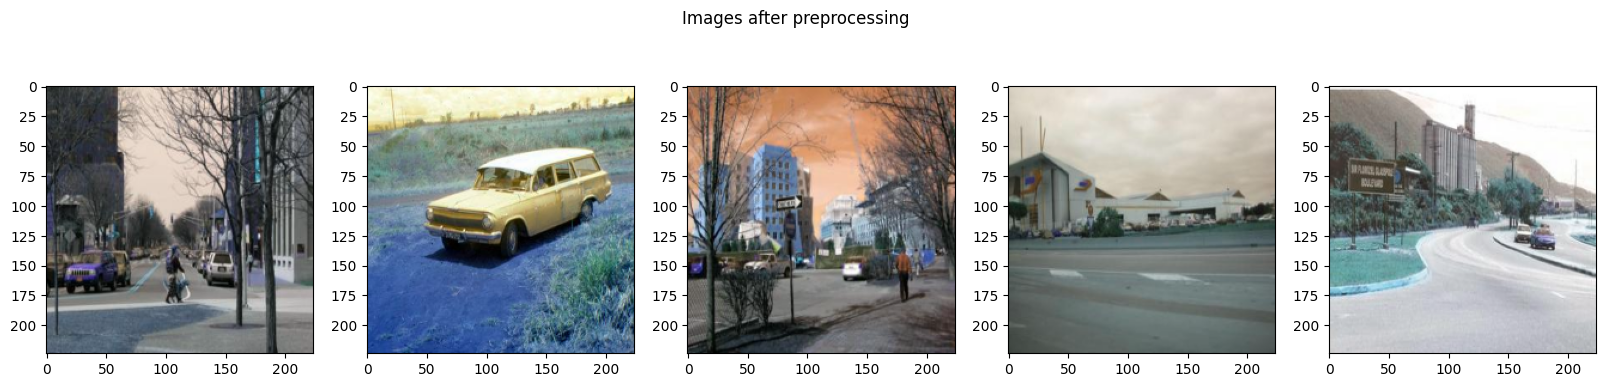

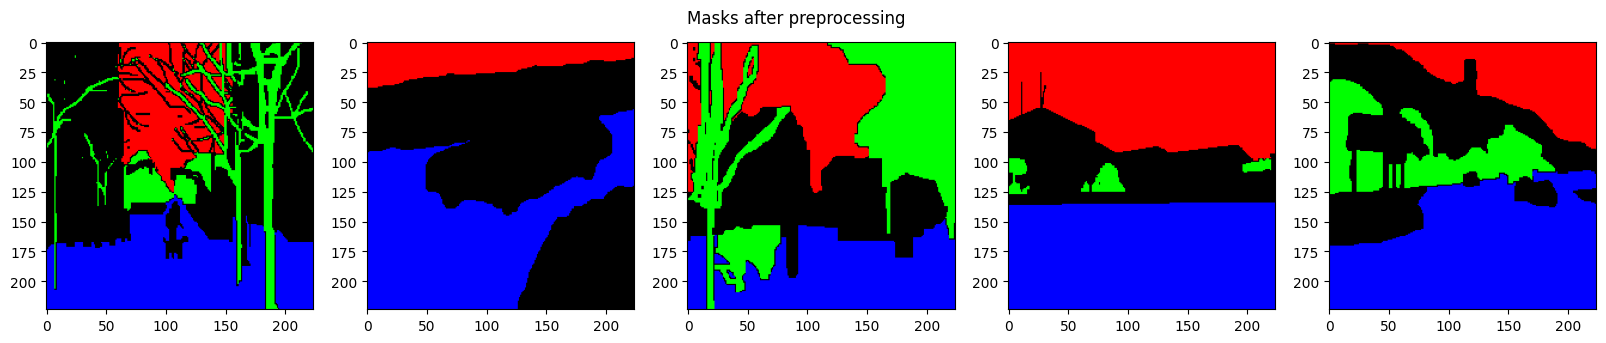

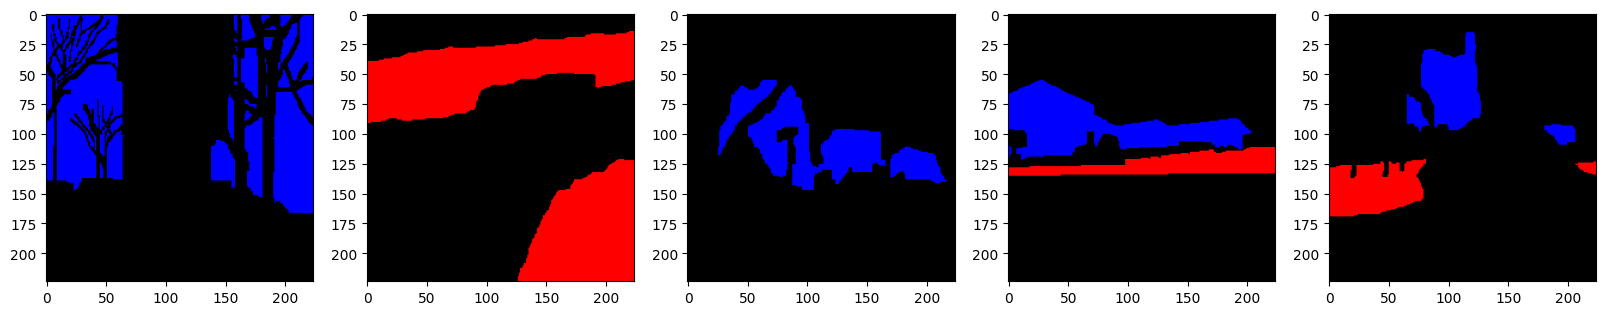

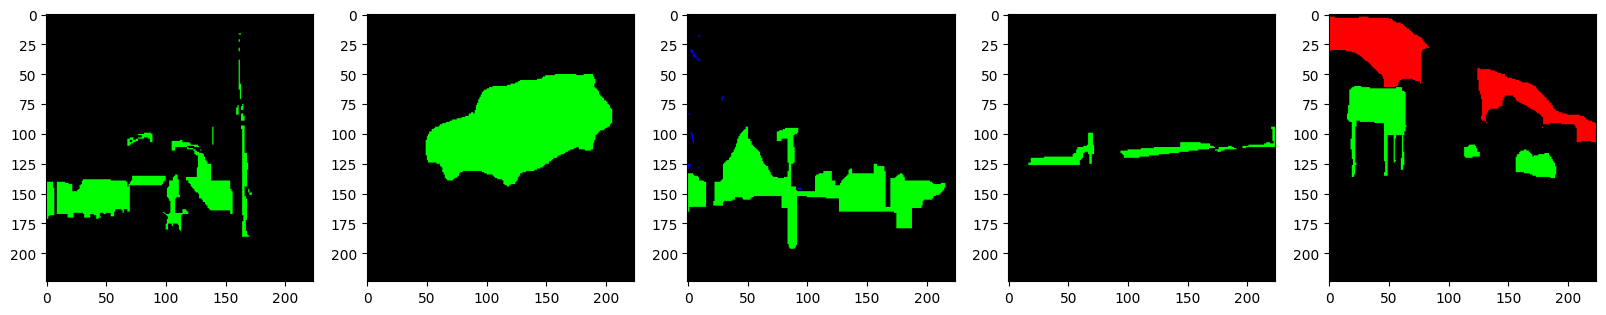

In [132]:
#Show data preprocessing
train_gen_visu = DataGenerator(train_images_paths, train_masks_paths)

imgs, masks = next(train_gen_visu)

plt.figure(figsize=(20, 20))
plt.suptitle('Images after preprocessing', x = 0.5, y = 0.6)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(imgs[i])

plt.figure(figsize=(20, 20))
plt.suptitle('Masks after preprocessing', x = 0.5, y = 0.85)
for j in range(5):
    ax = plt.subplot(3, 5, j + 1)
    ax.imshow(masks[j,:,:,:3])

for i in range(1,3):
    plt.figure(figsize=(20, 20))
    for j in range(5):
        ax = plt.subplot(3, 5, 5*i + j + 1)
        ax.imshow(masks[j,:,:,3*i:3*i+3])

In [133]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [134]:
from tensorflow.keras.applications import MobileNetV3Small

In [135]:
# Load the MobileNetV3 model

base_model = MobileNetV3Small(include_top=False,input_shape=(224, 224, 3))

# Add additional convolution layers to increase the receptive field
x = base_model.output

#Splitting the output of MobileNet V3 into two and applying different upscaling procedures

x2 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x) #first split to 1x1 conv
x2= Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')(x2)

#Old Model Architecture(still works)
# x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    
# # # Add upsampling layers to increase the resolution of the output
# x = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(filters=9, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)


x3= base_model.layers[7].output #Layer 7 from MobileNetV3

#Second section/split
x4=UpSampling2D()(x)
x4= AveragePooling2D(pool_size=(2,2),padding='same')(x4)
x4=Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')(x4)
x4=BatchNormalization()(x4)
x4=Activation('sigmoid')(x4)
x4=UpSampling2D(interpolation='bilinear')(x4)

x=concatenate([UpSampling2D(interpolation='bilinear')(x2),x4],axis=-1) #concatenate the two sections

#Upsample until the same shape as x3 is achieved
x=Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2DTranspose(filters=16,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)
x=BatchNormalization()(x)

#concatenate x with x3 and upsample until the same shape as input is achieved (224,224)
x=concatenate([x,x3],axis=-1)

#9 filters are for the 9 class labels. Necessary
x=Conv2DTranspose(filters=9,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same')(x)

#softmax activation at the end
x = Activation('softmax')(x)

    
# Define the model
model = Model(inputs=base_model.input, outputs=x)


# Print the model summary
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_36 (Rescaling)       (None, 224, 224, 3)  0           ['input_37[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_36[0][0]']           
                                )                                                                 
                                                                                           

In [136]:
model.compile(optimizer=Adam(learning_rate=0.001, decay=1e-06), loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
early_stop = EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True) #early stopping if performance of network does not improve

epochs = 100
batch_size = 35

history = model.fit(train_gen,
                epochs = epochs,
                steps_per_epoch=len(train_images_paths)//batch_size,
                validation_data=valid_gen,
                validation_steps=len(valid_images_paths)//batch_size,
                callbacks=[early_stop])

Epoch 1/100
18/18 [==============================] - 7s 195ms/step - loss: 2.2642 - accuracy: 0.2532 - val_loss: 1.7594 - val_accuracy: 0.3402
Epoch 2/100
18/18 [==============================] - 3s 147ms/step - loss: 1.5798 - accuracy: 0.4659 - val_loss: 1.7747 - val_accuracy: 0.3870
Epoch 3/100
18/18 [==============================] - 3s 148ms/step - loss: 1.3644 - accuracy: 0.5490 - val_loss: 1.4287 - val_accuracy: 0.5334
Epoch 4/100
18/18 [==============================] - 2s 144ms/step - loss: 1.2911 - accuracy: 0.5690 - val_loss: 1.3320 - val_accuracy: 0.5504
Epoch 5/100
18/18 [==============================] - 3s 145ms/step - loss: 1.1642 - accuracy: 0.6116 - val_loss: 1.2167 - val_accuracy: 0.6028
Epoch 6/100
18/18 [==============================] - 2s 144ms/step - loss: 1.0668 - accuracy: 0.6475 - val_loss: 1.2420 - val_accuracy: 0.5839
Epoch 7/100
18/18 [==============================] - 2s 144ms/step - loss: 0.9993 - accuracy: 0.6702 - val_loss: 1.2465 - val_accuracy: 0.6050

ACCURACY GRAPH

Text(0.5, 1.0, 'Accuracy')

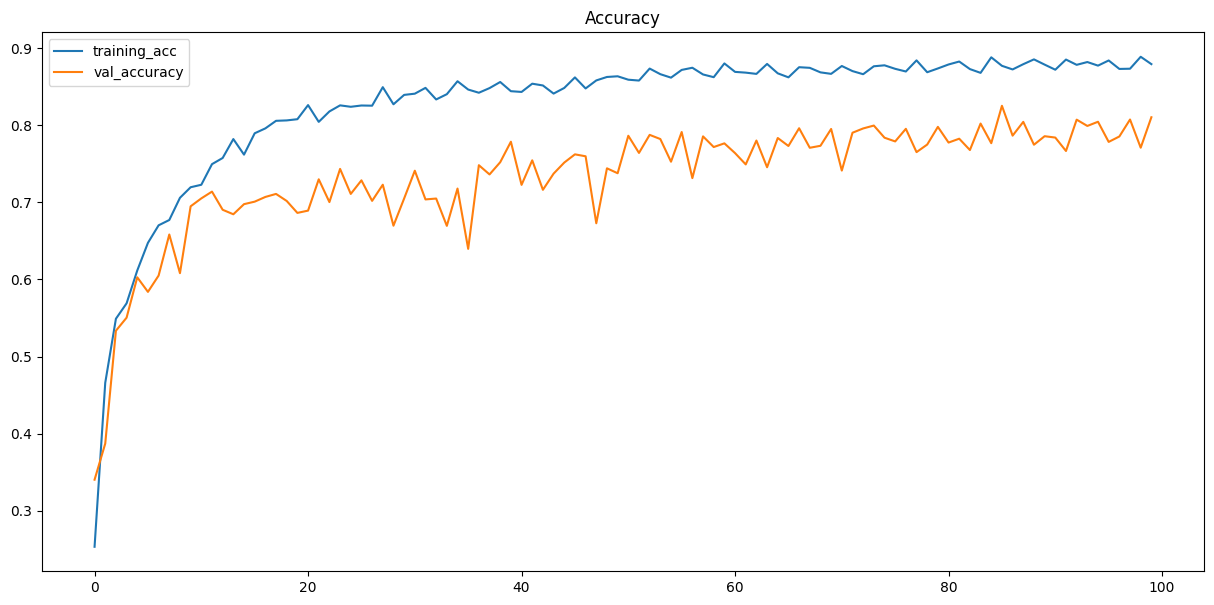

In [138]:

plt.figure(figsize=[15,7])
plt.plot(range(epochs),history.history['accuracy'])
plt.plot(range(epochs),history.history['val_accuracy'])
plt.legend(['training_acc','val_accuracy'])
plt.title('Accuracy')

LOSS CHART

Text(0.5, 1.0, 'Loss')

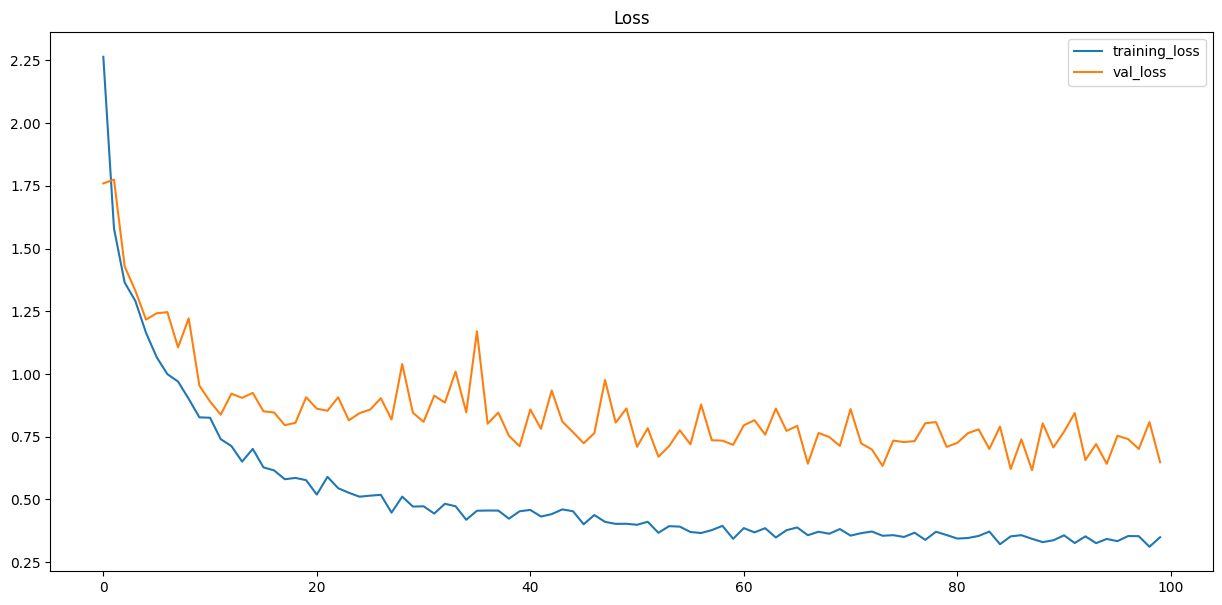

In [139]:
plt.figure(figsize=[15,7])
plt.plot(range(epochs),history.history['loss'])
plt.plot(range(epochs),history.history['val_loss'])
plt.legend(['training_loss','val_loss'])
plt.title('Loss')

PREDICTION WITH ANY IMAGE (place image in testimg folder)

1/1 [==============================] - 0s 75ms/step


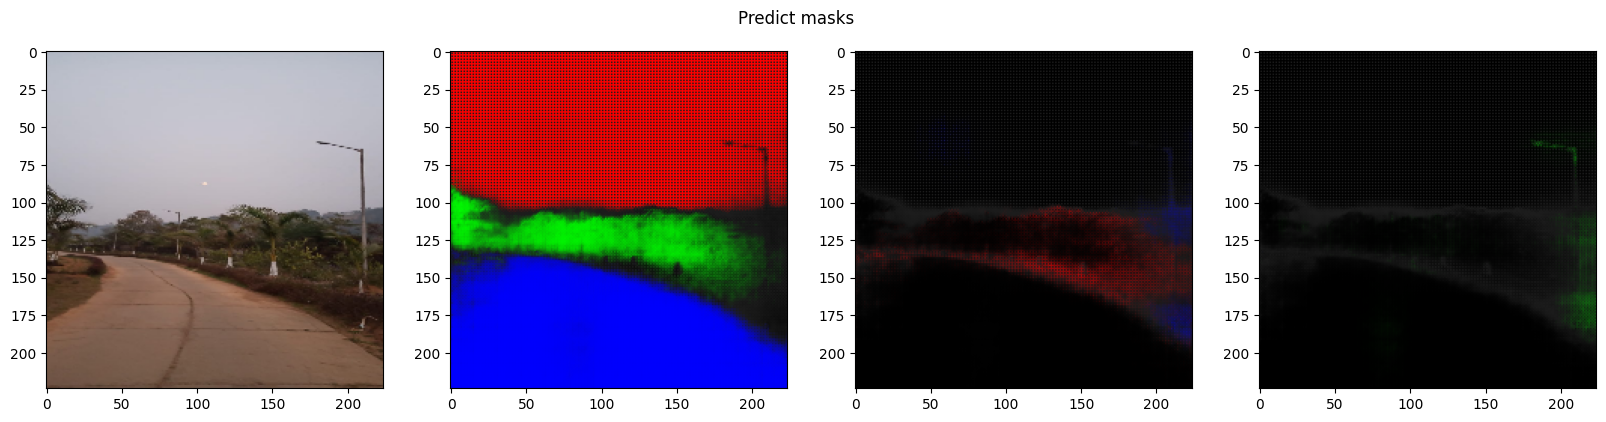

In [231]:
def convertimg(path):
    imgarr=[]
    im = cv2.resize(cv2.imread(path),(224,224))  #incase of size change
    imgarr.append(im)
    yield np.array(imgarr) 

image_test= r"./testimg/8.jpg" #PATH FOR NEW IMAGES. Change the image name to change img
im2=convertimg(image_test) #generator for resizing and convert to np.array
im=cv2.resize(cv2.imread(image_test),(224,224))
img_test=np.array(im)

predict_new = model.predict(im2) #get segmented masks 

# ax2= plt.subplot(1, 2, 1)
# ax2.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

# ax2 = plt.subplot(1, 2, 2)
# ax.imshow(imgs[0])
# for i in range(1):
#     ax2.imshow(predict_new[0,:,:,3*i:3*i+3])

#VISUALIZATION
plt.figure(figsize=(20, 20))
plt.suptitle('Predict masks', x = 0.5, y = 0.6)
ax2 = plt.subplot(1, 4, 1)
ax2.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
for i in range(3):
    ax2 = plt.subplot(1, 4, i + 2)
    ax2.imshow(predict_new[0,:,:,3*i:3*i+3])
    

PREDICTION FROM VALIDATION SET

1/1 [==============================] - 0s 25ms/step


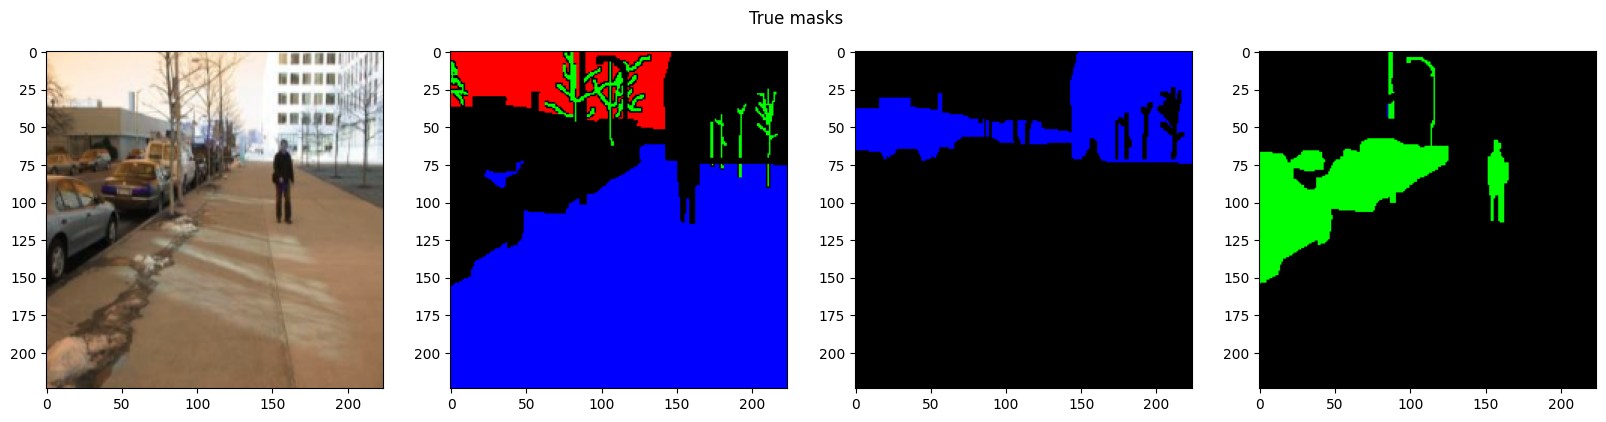

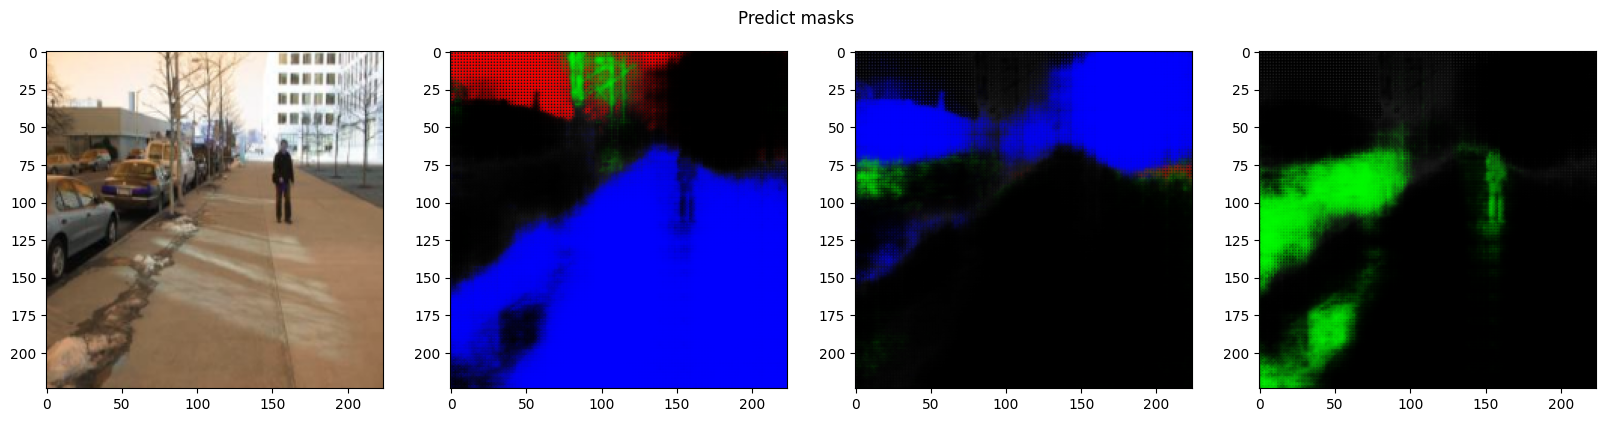

In [221]:
imgs, masks = next(valid_gen)

plt.figure(figsize=(20, 20))
plt.suptitle('True masks', x = 0.5, y = 0.6)
ax = plt.subplot(1, 4, 1)
ax.imshow(imgs[0])
for i in range(3):
    ax = plt.subplot(1, 4, i + 2)
    ax.imshow(masks[0,:,:,3*i:3*i+3])

predict_mask = model.predict(imgs)

plt.figure(figsize=(20, 20))
plt.suptitle('Predict masks', x = 0.5, y = 0.6)
ax = plt.subplot(1, 4, 1)
ax.imshow(imgs[0])
for i in range(3):
    ax = plt.subplot(1, 4, i + 2)
    ax.imshow(predict_mask[0,:,:,3*i:3*i+3])